Необходимо построить интерпретируемую вероятностную модель для задачи регрессии. Исследуются данные с ценами домов в качестве целевого признака и их характеристиками в качестве предикторов.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import bambi as bmb
import arviz as az

from statsmodels.formula.api import glm, ols
from sklearn.metrics import mean_squared_error, r2_score

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 1 Загрузка и подготовка данных

## 1.1 Загрузка и предварительный анализ данных

In [2]:
sample_sub = pd.read_csv('sample_submission.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train = pd.read_csv('train.csv')

In [5]:
sample_sub = sample_sub.set_index('Id')
sample_sub

,SalePrice
Id,
1461,169277.052498
1462,187758.393989
1463,183583.683570
1464,179317.477511
1465,150730.079977
...,...
2915,167081.220949
2916,164788.778231
2917,219222.423400


In [6]:
train = train.set_index('Id')
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [7]:
test = test.set_index('Id')
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuilt    

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearBuilt 

## 1.2 Предобработка данных

Выведем число пропусков в столбцах обучающей выборки.

In [10]:
train.isna().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtCond          37
BsmtQual          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
MSSubClass         0
dtype: int64

Удалим столбцы, где более 10 % пропусков.

In [11]:
almost_empty_cols = train.isna().sum()[train.isna().sum() > len(train) / 10].index

In [12]:
train = train.drop(columns = almost_empty_cols)
test = test.drop(columns = almost_empty_cols)

Выделим столбцы с численными и категориальными значениями (в столбцах с численными значениями могут быть категориальные переменные).

In [13]:
train_num = train.loc[:,(train.dtypes != 'object').values].drop(columns=['SalePrice'])
test_num = test[train_num.columns]

In [14]:
train_num

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,8450,7,5,2003,2003,196.0,706,0,150,...,548,0,61,0,0,0,0,0,2,2008
2,20,9600,6,8,1976,1976,0.0,978,0,284,...,460,298,0,0,0,0,0,0,5,2007
3,60,11250,7,5,2001,2002,162.0,486,0,434,...,608,0,42,0,0,0,0,0,9,2008
4,70,9550,7,5,1915,1970,0.0,216,0,540,...,642,0,35,272,0,0,0,0,2,2006
5,60,14260,8,5,2000,2000,350.0,655,0,490,...,836,192,84,0,0,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,7917,6,5,1999,2000,0.0,0,0,953,...,460,0,40,0,0,0,0,0,8,2007
1457,20,13175,6,6,1978,1988,119.0,790,163,589,...,500,349,0,0,0,0,0,0,2,2010
1458,70,9042,7,9,1941,2006,0.0,275,0,877,...,252,0,60,0,0,0,0,2500,5,2010


In [15]:
train_obj = train.loc[:,(train.dtypes == 'object').values]
test_obj = test[train_obj.columns]

In [16]:
train_obj

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
4,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
5,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,SBrkr,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


Обработаем столбцы с категориальными переменными.

In [17]:
train_obj.describe()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,Electrical,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1459,1460,1460,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,1334,735,1360,870,605,1311,1326,1340,1267,1198


Удалим столбцы, где более 80 % встречатеся одно значение.

In [18]:
train_obj.describe().T[train_obj.describe().T['freq'] > (len(train) * 0.8)]

,count,unique,top,freq
Street,1460,2,Pave,1454
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LandSlope,1460,3,Gtl,1382
Condition1,1460,9,Norm,1260
Condition2,1460,8,Norm,1445
BldgType,1460,5,1Fam,1220
RoofMatl,1460,8,CompShg,1434
ExterCond,1460,5,TA,1282
BsmtCond,1423,4,TA,1311


In [19]:
const_obj_cols = train_obj.describe().T[train_obj.describe().T['freq'] > (len(train) * 0.8)].index

In [20]:
train_obj = train_obj.drop(columns=const_obj_cols)
test_obj = test_obj.drop(columns=const_obj_cols)

In [21]:
train_obj

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish
Id,,,,,,,,,,,,,,,,,
1,RL,Reg,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,Gd,PConc,Gd,No,GLQ,Ex,Gd,Attchd,RFn
2,RL,Reg,FR2,Veenker,1Story,Gable,MetalSd,MetalSd,TA,CBlock,Gd,Gd,ALQ,Ex,TA,Attchd,RFn
3,RL,IR1,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,Gd,PConc,Gd,Mn,GLQ,Ex,Gd,Attchd,RFn
4,RL,IR1,Corner,Crawfor,2Story,Gable,Wd Sdng,Wd Shng,TA,BrkTil,TA,No,ALQ,Gd,Gd,Detchd,Unf
5,RL,IR1,FR2,NoRidge,2Story,Gable,VinylSd,VinylSd,Gd,PConc,Gd,Av,GLQ,Ex,Gd,Attchd,RFn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,TA,PConc,Gd,No,Unf,Ex,TA,Attchd,RFn
1457,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,TA,CBlock,Gd,No,ALQ,TA,TA,Attchd,Unf
1458,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,Ex,Stone,TA,No,GLQ,Ex,Gd,Attchd,RFn


In [22]:
train_obj.describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
LotShape,1460,4,Reg,925
LotConfig,1460,5,Inside,1052
Neighborhood,1460,25,NAmes,225
HouseStyle,1460,8,1Story,726
RoofStyle,1460,6,Gable,1141
Exterior1st,1460,15,VinylSd,515
Exterior2nd,1460,16,VinylSd,504
ExterQual,1460,4,TA,906
Foundation,1460,6,PConc,647


Обработаем столбцы с пропусками.

In [23]:
train_obj[train_obj['GarageType'].isna()][['GarageType', 'GarageFinish']].isna().mean()

GarageType      1.0
GarageFinish    1.0
dtype: float64

In [24]:
train_obj[train_obj['BsmtExposure'].isna()][['BsmtQual', 'BsmtExposure', 'BsmtFinType1']].isna().mean()

BsmtQual        0.973684
BsmtExposure    1.000000
BsmtFinType1    0.973684
dtype: float64

Пропуски есть в одних и тех же объектах. Вероятно, они означают отсутствие объекта (гаража или цокольного этажа). Заменим их на `'No'`.

In [25]:
train_obj.fillna('No', inplace=True)
test_obj.fillna('No', inplace=True)

Обработаем столбцы с численными переменными (с учетом возможных категориальных).

In [26]:
train_num.describe().T

,count,mean,std,min,25%,50%,75%,max
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.00,0.0,166.00,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0
BsmtFinSF2,1460.0,46.549315,161.319273,0.0,0.00,0.0,0.00,1474.0
BsmtUnfSF,1460.0,567.240411,441.866955,0.0,223.00,477.5,808.00,2336.0


В численных данных есть два столбца с пропусками - `'MasVnrArea'` и `'GarageYrBlt'`. Это площадь облицовки каменной кладки и год постройки гаража. Заменим здесь пропуски на 0.

In [27]:
train_num.fillna(0, inplace=True)
test_num.fillna(0, inplace=True)

C:\Users\Demina.LV\AppData\Local\Temp\ipykernel_10764\1951955432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_num.fillna(0, inplace=True)


In [28]:
train_num.isna().mean().mean()

0.0

Аналогично из численных столбцов удалим те, в которых более 80 % одно значение.

In [29]:
train_num.astype('str').describe().T

,count,unique,top,freq
MSSubClass,1460,15,20,536
LotArea,1460,1073,7200,25
OverallQual,1460,10,5,397
OverallCond,1460,9,5,821
YearBuilt,1460,112,2006,67
YearRemodAdd,1460,61,1950,178
MasVnrArea,1460,327,0.0,869
BsmtFinSF1,1460,637,0,467
BsmtFinSF2,1460,144,0,1293
BsmtUnfSF,1460,780,0,118


In [30]:
const_num_cols = train_num.astype('str').describe().T[train_num.astype('str').describe().T['freq'] > (len(train) * 0.8)].index

In [31]:
const_num_cols

Index(['BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [32]:
train_num = train_num.drop(columns=const_num_cols)
test_num = test_num.drop(columns=const_num_cols)

In [33]:
train_num.shape

(1460, 26)

In [34]:
train_obj.shape

(1460, 17)

# 2 Обучение моделей

Для анализа работы разных моделей возьмем в качестве предикторов два столбца - год постройки и площадь.

In [35]:
features = ['YearBuilt', 'LotArea']

In [36]:
columns_alias = {}

for i, col in enumerate(features):
    columns_alias[col] = f'X{i+1}'

In [37]:
data = train_num[features].rename(columns=columns_alias)
data['y'] = train['SalePrice']

In [38]:
data

,X1,X2,y
Id,,,
1,2003,8450,208500
2,1976,9600,181500
3,2001,11250,223500
4,1915,9550,140000
5,2000,14260,250000
...,...,...,...
1456,1999,7917,175000
1457,1978,13175,210000
1458,1941,9042,266500


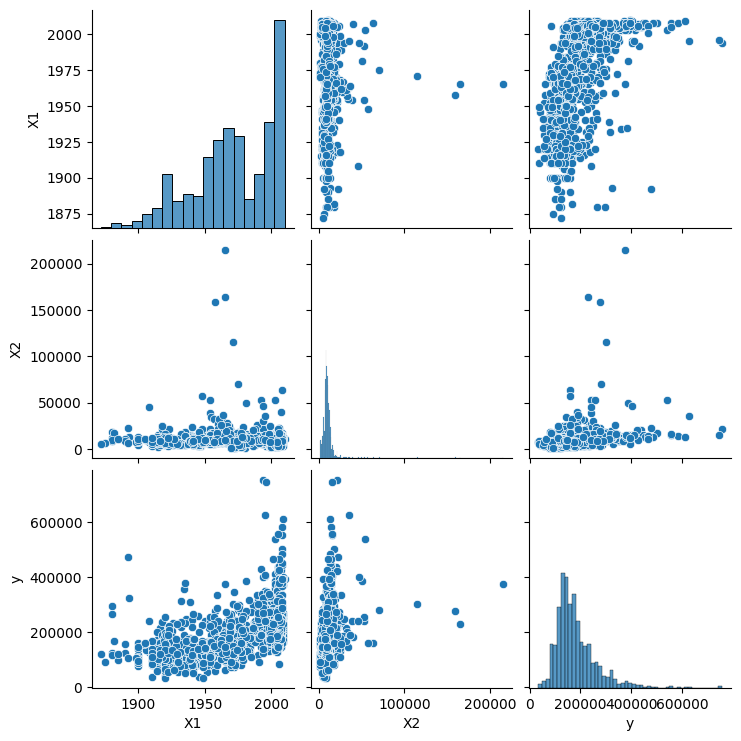

In [39]:
sns.pairplot(data);

In [40]:
test_num

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,...,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,11622,5,6,1961,1961,0.0,468.0,270.0,882.0,...,2,5,0,1961.0,1.0,730.0,140,0,6,2010
1462,20,14267,6,6,1958,1958,108.0,923.0,406.0,1329.0,...,3,6,0,1958.0,1.0,312.0,393,36,6,2010
1463,60,13830,5,5,1997,1998,0.0,791.0,137.0,928.0,...,3,6,1,1997.0,2.0,482.0,212,34,3,2010
1464,60,9978,6,6,1998,1998,20.0,602.0,324.0,926.0,...,3,7,1,1998.0,2.0,470.0,360,36,6,2010
1465,120,5005,8,5,1992,1992,0.0,263.0,1017.0,1280.0,...,2,5,0,1992.0,2.0,506.0,0,82,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,...,3,5,0,0.0,0.0,0.0,0,0,6,2006
2916,160,1894,4,5,1970,1970,0.0,252.0,294.0,546.0,...,3,6,0,1970.0,1.0,286.0,0,24,4,2006
2917,20,20000,5,7,1960,1996,0.0,1224.0,0.0,1224.0,...,4,7,1,1960.0,2.0,576.0,474,0,9,2006


In [41]:
X_test = test_num[features].rename(columns=columns_alias)

## 2.1 OLS

Построим модель линейной регрессии с помощью OLS.

In [42]:
formula = 'y ~ ' + ' + '.join(data.drop(columns=['y']).columns.to_list())
formula

'y ~ X1 + X2'

In [43]:
model = ols(formula = formula, data = data).fit()

In [44]:
model.params

Intercept   -2.532856e+06
X1           1.365776e+03
X2           2.041172e+00
dtype: float64

In [45]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     373.9
Date:                Thu, 01 Aug 2024   Prob (F-statistic):          8.54e-132
Time:                        12:01:48   Log-Likelihood:                -18242.
No. Observations:                1460   AIC:                         3.649e+04
Df Residuals:                    1457   BIC:                         3.651e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.533e+06    1.1e+05    -22.935      0.0

## 2.2 LinReg

Построим модель линейной регрессии с помощью GLM.

In [46]:
model_glm = glm(formula = formula,
                data = data,
                family = sm.families.Gaussian()).fit()

print(model_glm.params)

Intercept   -2.532856e+06
X1           1.365776e+03
X2           2.041172e+00
dtype: float64


In [47]:
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1457
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                      4.1762e+09
Method:                          IRLS   Log-Likelihood:                -18242.
Date:                Thu, 01 Aug 2024   Deviance:                   6.0848e+12
Time:                        12:01:48   Pearson chi2:                 6.08e+12
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4008
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.533e+06    1.1e+05    -22.935      0.0

Метрика R2 у этих двух моделей почти не отличается.

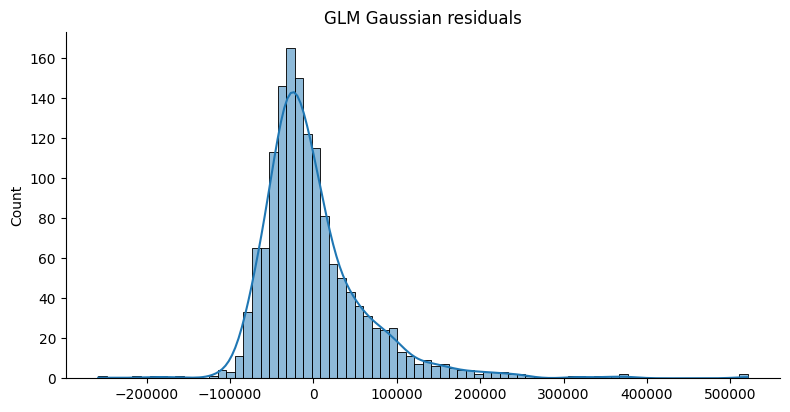

In [48]:
# распределение остатков
residuals = model_glm.resid_deviance
sns.displot(residuals, kde=True, height=4, aspect=2)
plt.title("GLM Gaussian residuals");

Рассчитаем метрики R2 и RMSE на тестовых данных.

In [49]:
pred = model_glm.predict(X_test)

In [50]:
metrics = pd.DataFrame(columns=['R2', 'RMSE'])

In [51]:
metrics.loc['LinReg', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['LinReg', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [52]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862


## 2.3 LinReg log

Распределение таргета похоже на логнормальное.

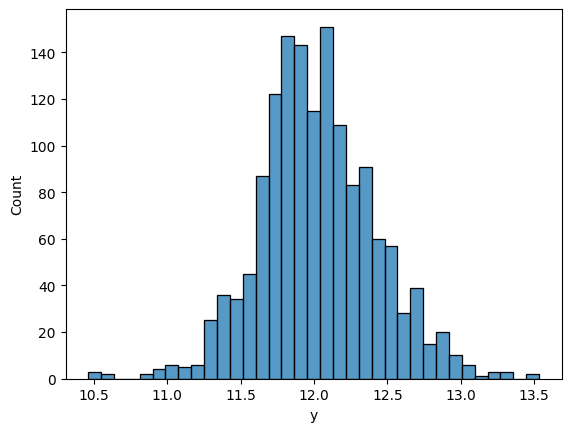

In [53]:
sns.histplot(np.log(data['y']));

Построим модель линейной регрессии на прологарифмированном таргете.

In [54]:
data_log = data.copy()

In [55]:
data_log['y'] = np.log(data['y'])

In [56]:
model_glm_log = glm(formula = formula,
                data = data_log,
                family = sm.families.Gaussian()).fit()

print(model_glm_log.params)

Intercept   -3.280991
X1           0.007711
X2           0.000010
dtype: float64


In [57]:
print(model_glm_log.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1457
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.094899
Method:                          IRLS   Log-Likelihood:                -351.04
Date:                Thu, 01 Aug 2024   Deviance:                       138.27
Time:                        12:01:48   Pearson chi2:                     138.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4945
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.2810      0.526     -6.232      0.0

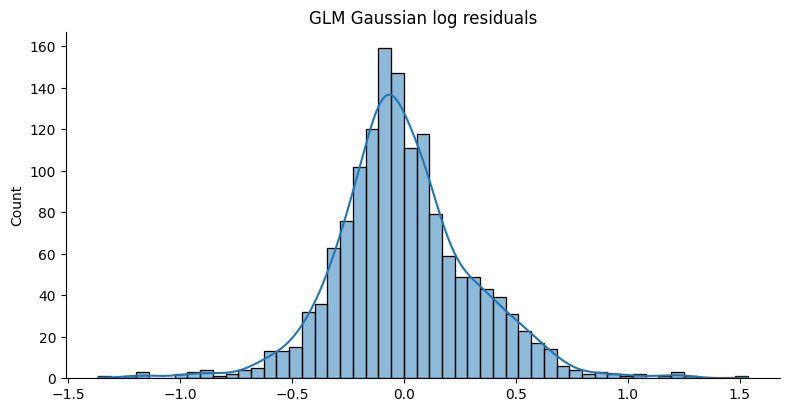

In [58]:
# распределение остатков
residuals = model_glm_log.resid_deviance
sns.displot(residuals, kde=True, height=4, aspect=2)
plt.title("GLM Gaussian log residuals");

In [59]:
pred = np.exp(model_glm_log.predict(X_test))

In [60]:
metrics.loc['LinReg_log', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['LinReg_log', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [61]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701


## 2.4 GLM Gamma

Построим модель GLM с Gamma-распределением таргета.

In [62]:
link_function = sm.families.links.Identity()
model_family = sm.families.Gamma(link = link_function)

In [63]:
model_glm_gamma = glm(formula = formula,
                data = data,
                family = model_family).fit()

print(model_glm_gamma.params)

Intercept   -1.805516e+06
X1           9.758931e+02
X2           6.052766e+00
dtype: float64


c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [64]:
print(model_glm_gamma.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1457
Model Family:                   Gamma   Df Model:                            2
Link Function:               Identity   Scale:                         0.10286
Method:                          IRLS   Log-Likelihood:                -17912.
Date:                Thu, 01 Aug 2024   Deviance:                       136.49
Time:                        12:01:49   Pearson chi2:                     150.
No. Iterations:                    28   Pseudo R-squ. (CS):             0.4939
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.806e+06   7.86e+04    -22.983      0.0

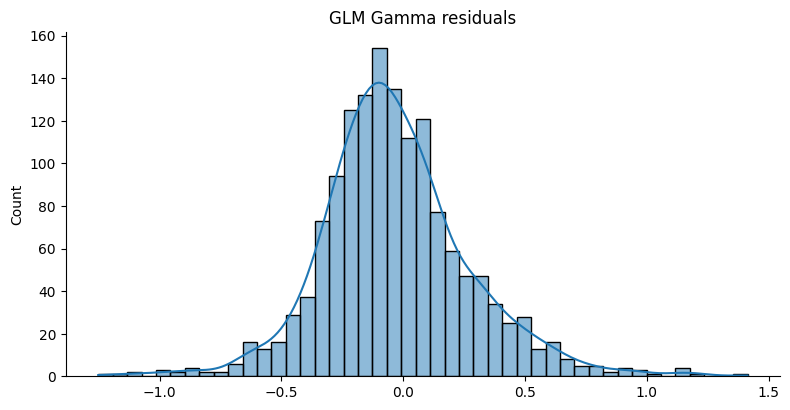

In [65]:
# распределение остатков
residuals = model_glm_gamma.resid_deviance
sns.displot(residuals, kde=True, height=4, aspect=2)
plt.title("GLM Gamma residuals");

In [66]:
pred = model_glm_gamma.predict(X_test)

In [67]:
metrics.loc['GLM Gamma', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['GLM Gamma', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [68]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672


## 2.5 GLM InverseGaussian

Построим модель GLM с распределением таргета InverseGaussian.

In [69]:
link_function = sm.families.links.Identity()
model_family = sm.families.InverseGaussian(link = link_function)

In [70]:
model_glm_inv_gauss = glm(formula = formula,
                data = data,
                family = model_family).fit()

print(model_glm_inv_gauss.params)

Intercept   -1.574237e+06
X1           8.539305e+02
X2           6.904607e+00
dtype: float64


c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The Identity link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [71]:
print(model_glm_inv_gauss.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1460
Model:                            GLM   Df Residuals:                     1457
Model Family:         InverseGaussian   Df Model:                            2
Link Function:               Identity   Scale:                      5.6761e-07
Method:                          IRLS   Log-Likelihood:                -17890.
Date:                Thu, 01 Aug 2024   Deviance:                   0.00081073
Time:                        12:01:49   Pearson chi2:                 0.000827
No. Iterations:                    46   Pseudo R-squ. (CS):             0.5155
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.574e+06   6.96e+04    -22.624      0.0

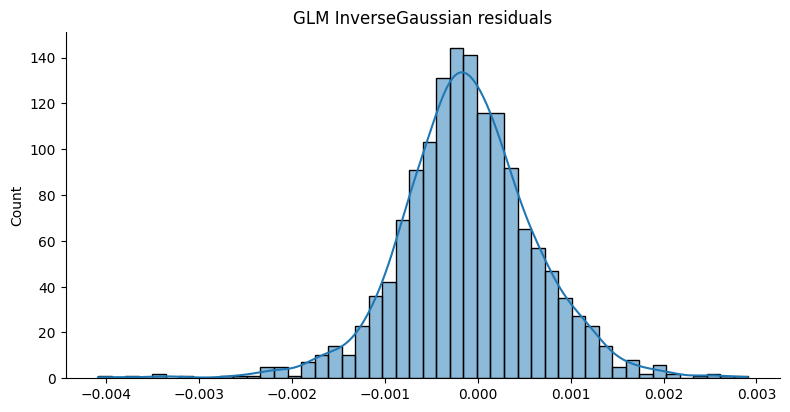

In [72]:
# распределение остатков
residuals = model_glm_inv_gauss.resid_deviance
sns.displot(residuals, kde=True, height=4, aspect=2)
plt.title("GLM InverseGaussian residuals");

In [73]:
pred = model_glm_inv_gauss.predict(X_test)

In [74]:
metrics.loc['GLM InvGauss', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['GLM InvGauss', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [75]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672
GLM InvGauss,-4.100275,37291.801243


## 2.6 Bayesian LR

Построим вероятностную модель линейной регрессии с помощью фреймворка `bambi`. Трассировка модели занимает много времени, поэтому сократим число сэмплов до 30.

In [89]:
model = bmb.Model(formula, data)
idata = model.fit(draws=30, chains=1, tune=3) # sample

Only 30 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, Intercept, X1, X2]


Output()

Sampling 1 chain for 3 tune and 30 draw iterations (3 + 30 draws total) took 454 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


Sampling: [Intercept, X1, X2, sigma]


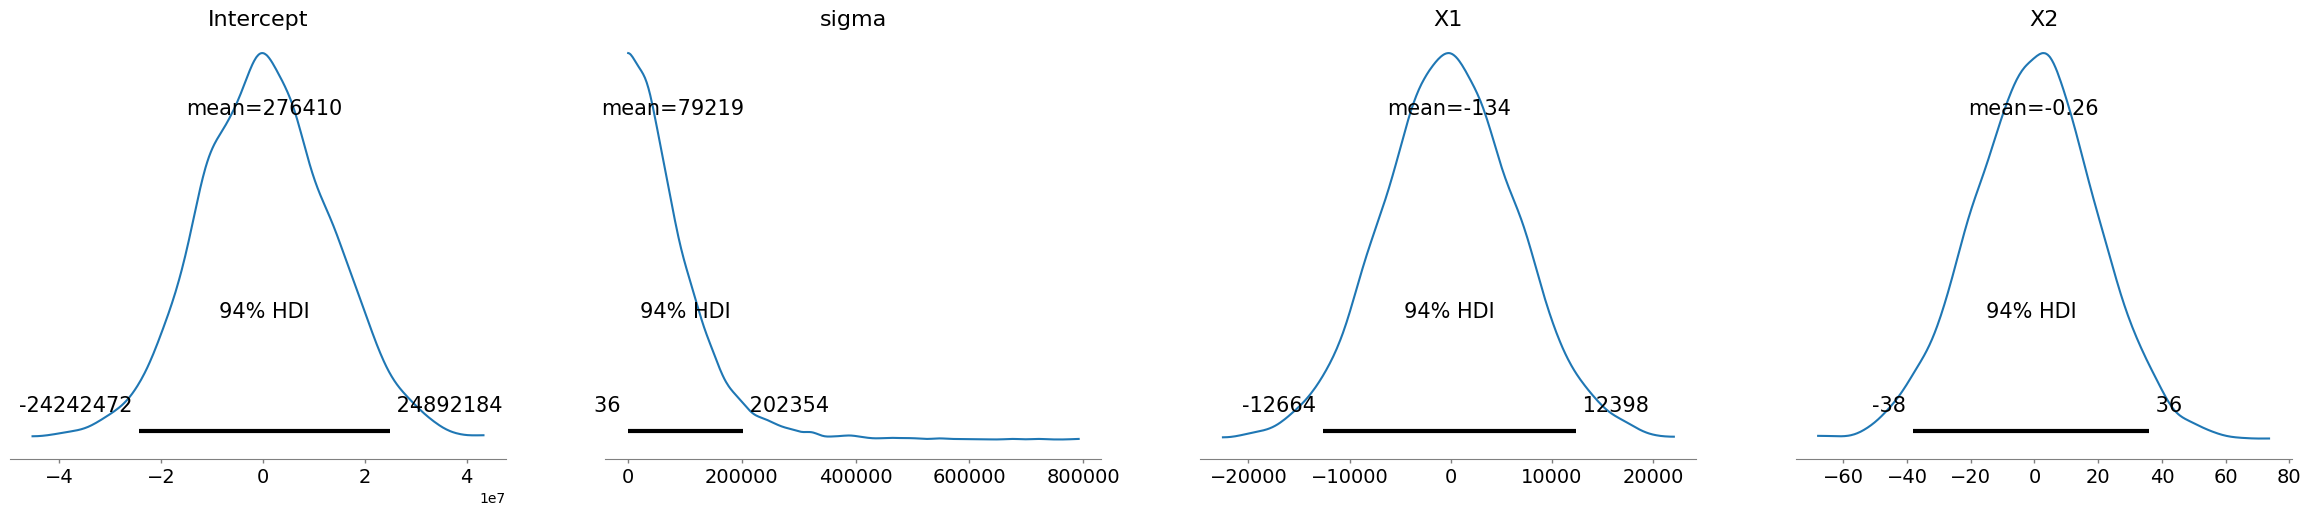

In [90]:
model.plot_priors();

In [91]:
model

       Formula: y ~ X1 + X2
        Family: gaussian
          Link: mu = identity
  Observations: 1460
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 180921.1959, sigma: 12965741.5457)
            X1 ~ Normal(mu: 0.0, sigma: 6575.7338)
            X2 ~ Normal(mu: 0.0, sigma: 19.8979)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 79415.2919)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

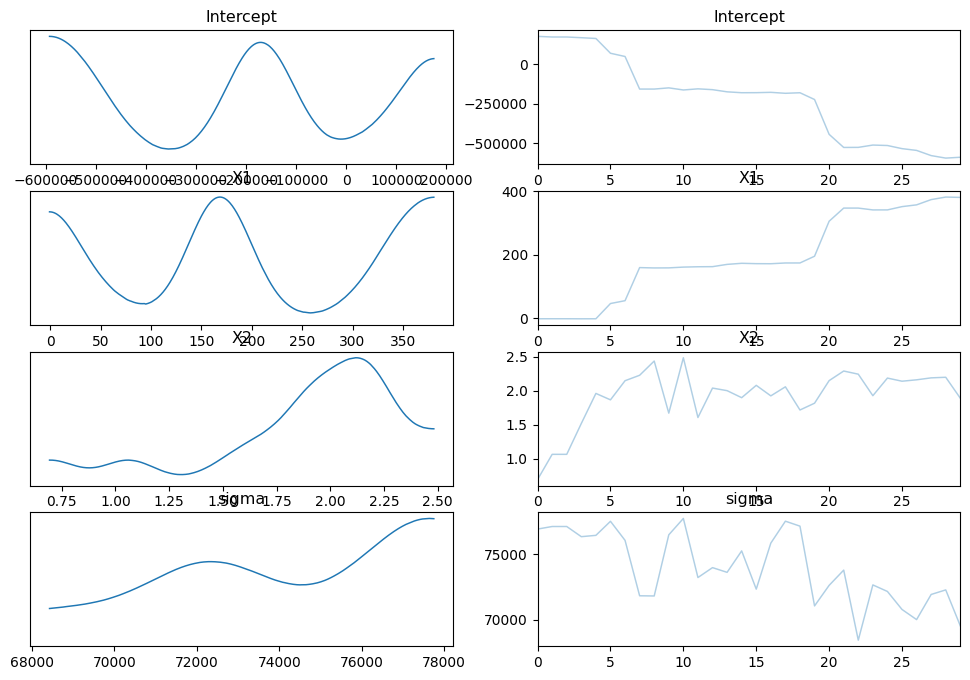

In [92]:
az.plot_trace(idata);

По графикам видно, что модель не сходится. Вероятно, из-за допущения о нормальном распределении правдоподобия.

array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'X1'}>, <Axes: title={'center': 'X2'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

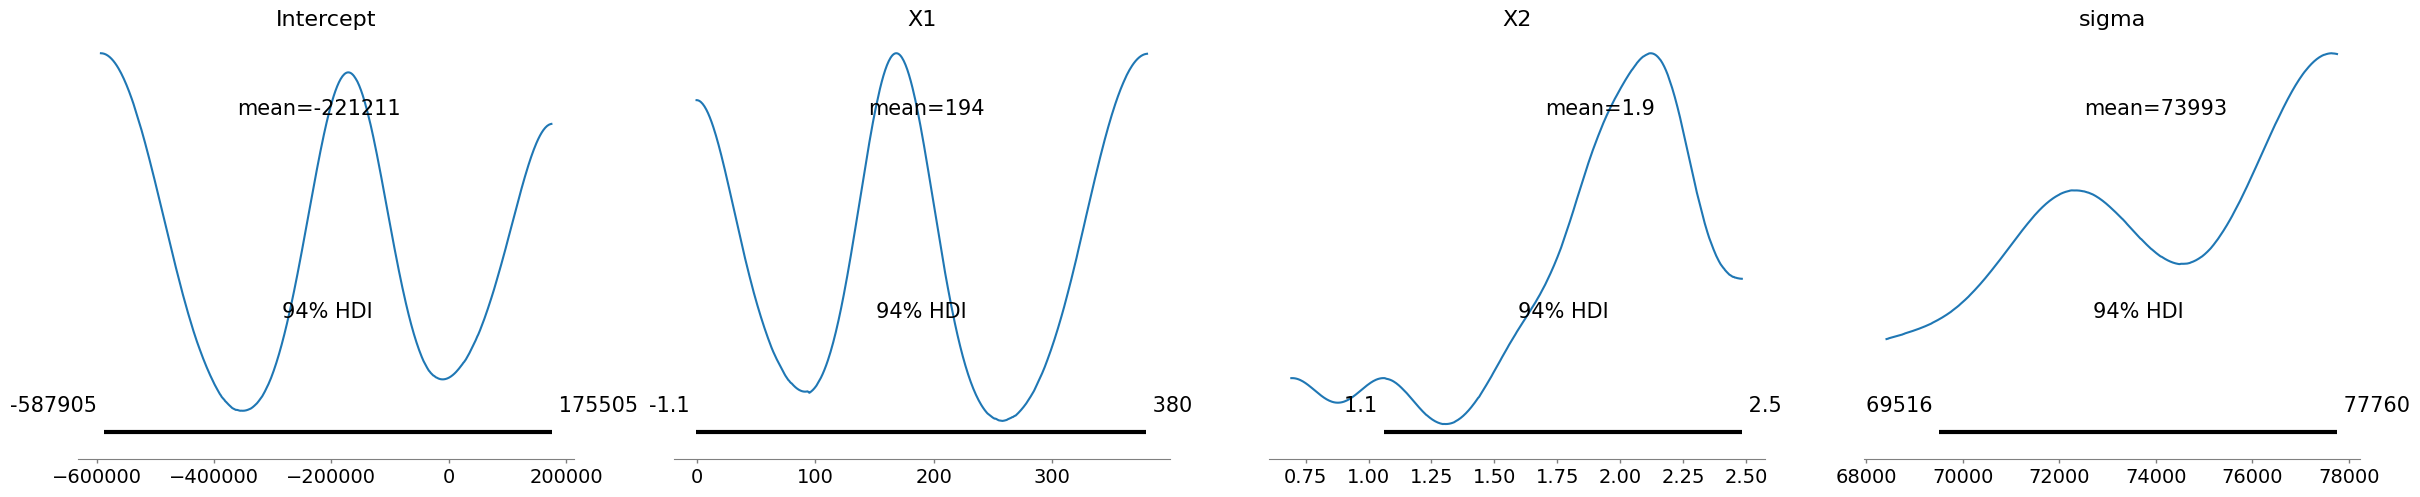

In [93]:
az.plot_posterior(idata)

In [94]:
model.predict(idata, kind='response')

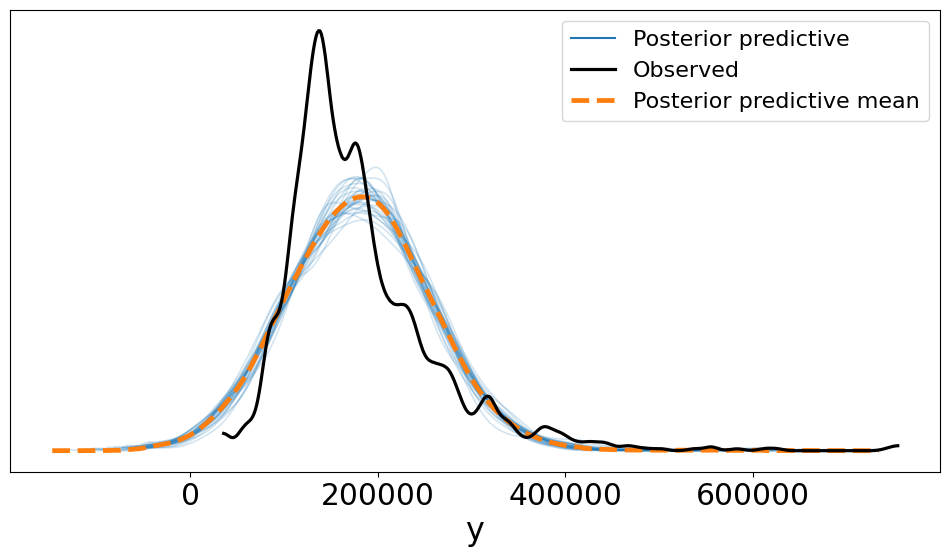

In [95]:
az.plot_ppc(idata, figsize=(12, 6));

In [96]:
model.predict(idata, kind="response", data=X_test)

In [97]:
idata.posterior_predictive.y

<xarray.DataArray 'y' (chain: 1, draw: 30, __obs__: 1459)> Size: 350kB
array([[[101989.0624963 , 194322.00770856, 155701.12236914, ...,
         138682.68815708, 274981.33873316, 231596.9613208 ],
        [229569.13287571, 101979.41116253, 259394.62436171, ...,
         231703.05451761, 125600.56027294, 165060.91109769],
        [131660.28759185, 223065.98074352, 110368.31556786, ...,
         263917.77469477, 283337.80689919, 171856.30011074],
        ...,
        [218324.05340793, 142651.35056966, 177135.11566748, ...,
         181550.66741248, 163938.72125057, 243998.17176439],
        [245204.41017934, 272754.06008755, 318915.44131074, ...,
          95826.01323238, -11370.13294855,  37593.33489725],
        [ 50803.70243017,  55532.14395764, 213846.72421448, ...,
         261704.64986302, 236329.92062916, 191788.086055  ]]])
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 120B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * __obs__  (__obs__) int32 6kB 0 1 2 3 4 5 6 ... 1453 1454 1455 1456 1457 1458

In [98]:
pred = np.array(idata.posterior_predictive.y.mean(dim=['draw']))[0]

In [99]:
metrics.loc['Bayesian LR', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['Bayesian LR', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [100]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672
GLM InvGauss,-4.100275,37291.801243
Bayesian LR,-0.318454,18960.470392


Несмотря на то, что модель имеет плохую сходимость, ее качество на тестовых данных намного выше, чем у предыдущих моделей единичной оценки.

## 2.7 Bayesian GLM t

Построим вероятностную модель с t-распределением правдоподобия.

In [101]:
model = bmb.Model(formula, data, family='t')
idata = model.fit(draws=30, chains=1, tune=3) # sample

Only 30 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, nu, Intercept, X1, X2]


Output()

c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\scalar\basic.py:3200: RuntimeWarning: 
overflow encountered in scalar multiply
  return x * x

c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\scalar\basic.py:2000: RuntimeWarning: 
invalid value encountered in divide
  return x / y

c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\tensor\elemwise.py:754: RuntimeWarning: 
invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)

c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\scalar\basic.py:2926: RuntimeWarning: 
divide by zero encountered in log
  return np.log(x)

Sampling 1 chain for 3 tune and 30 draw iterations (3 + 30 draws total) took 1100 seconds.
The number of samples is too small to check convergence reliably.


Sampling: [Intercept, X1, X2, nu, sigma]


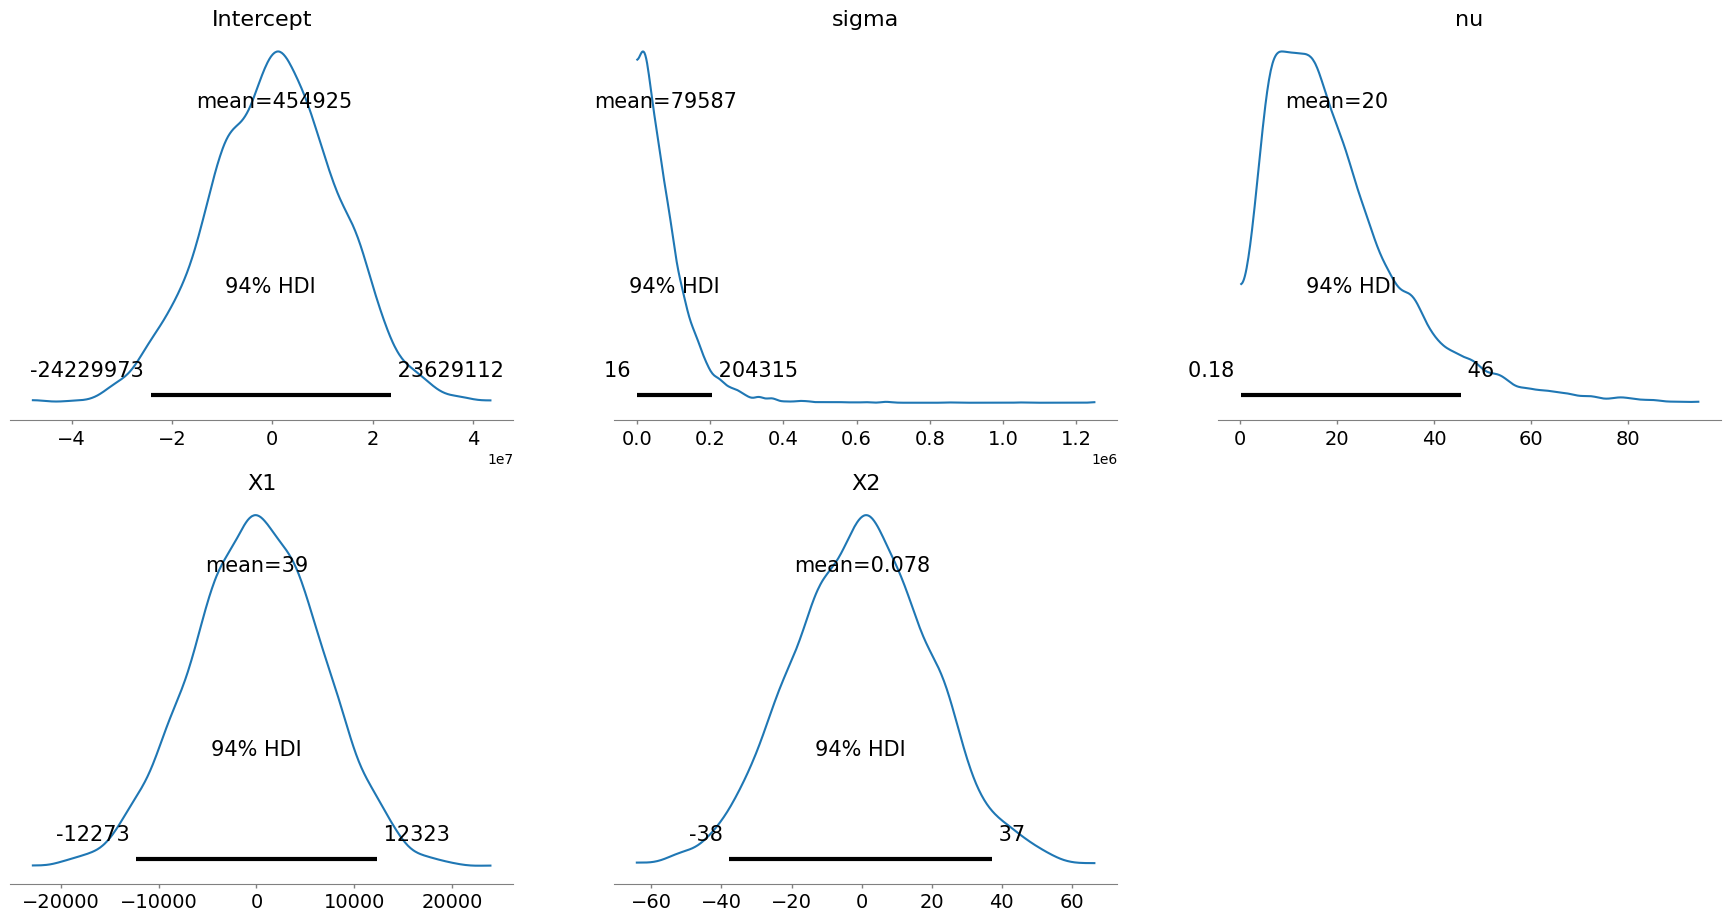

In [102]:
model.plot_priors();

In [103]:
model

       Formula: y ~ X1 + X2
        Family: t
          Link: mu = identity
  Observations: 1460
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 180921.1959, sigma: 12965741.5457)
            X1 ~ Normal(mu: 0.0, sigma: 6575.7338)
            X2 ~ Normal(mu: 0.0, sigma: 19.8979)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 79415.2919)
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

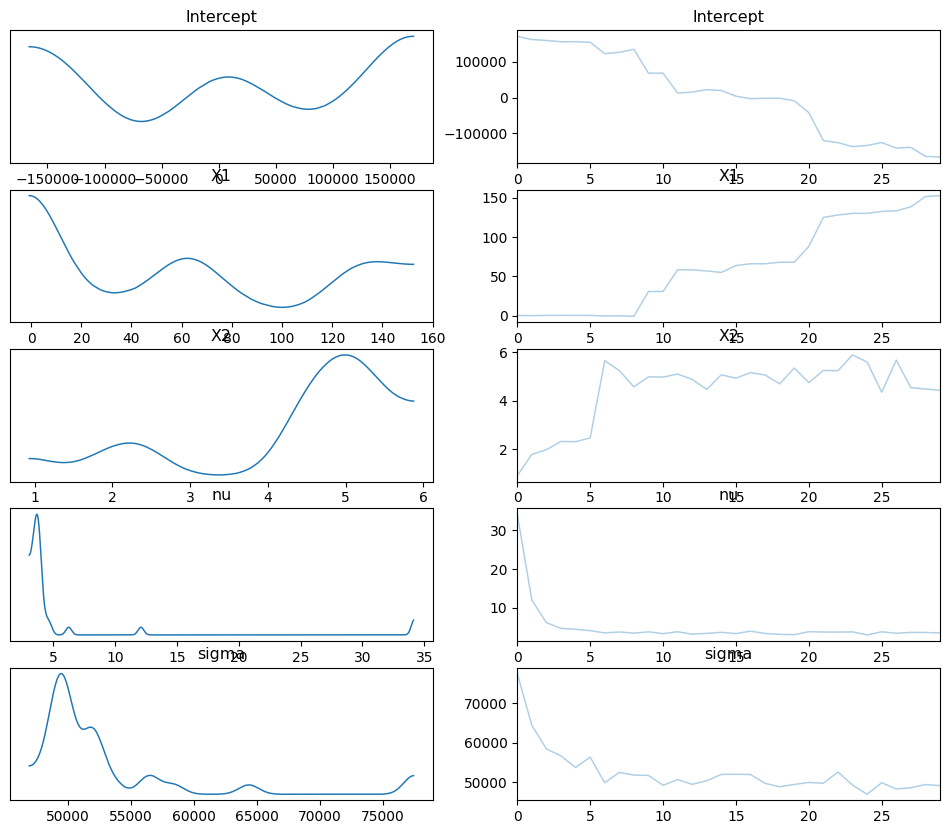

In [104]:
az.plot_trace(idata);

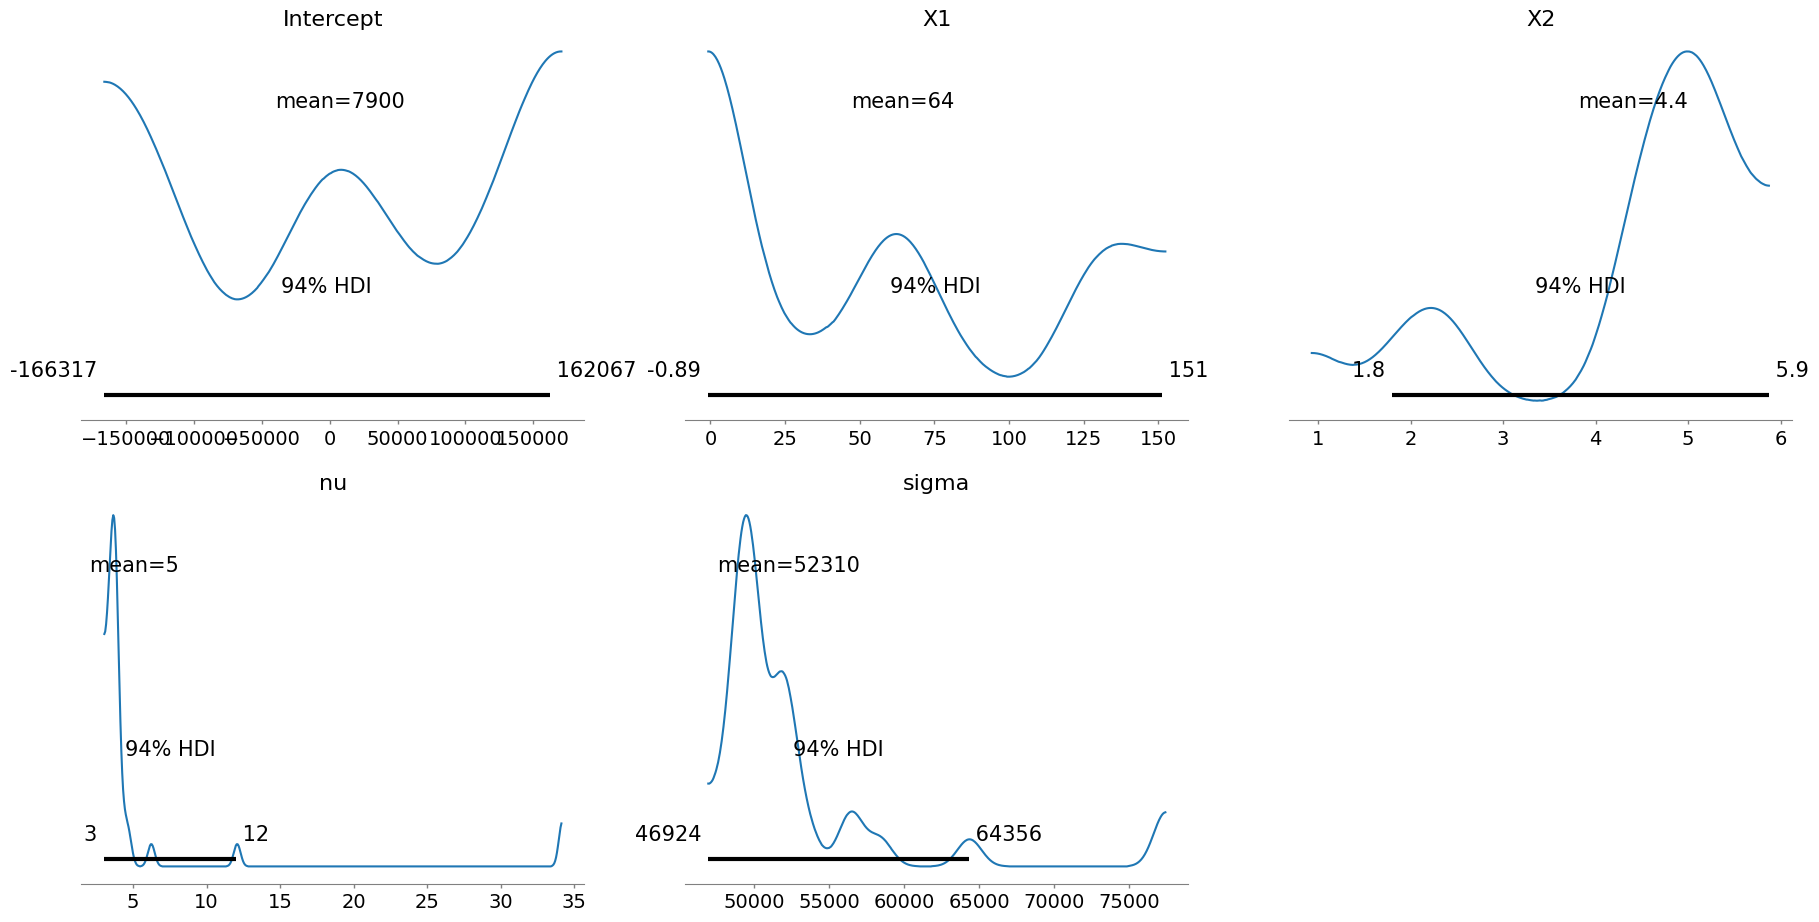

In [106]:
az.plot_posterior(idata);

In [107]:
model.predict(idata, kind='response', inplace=True)

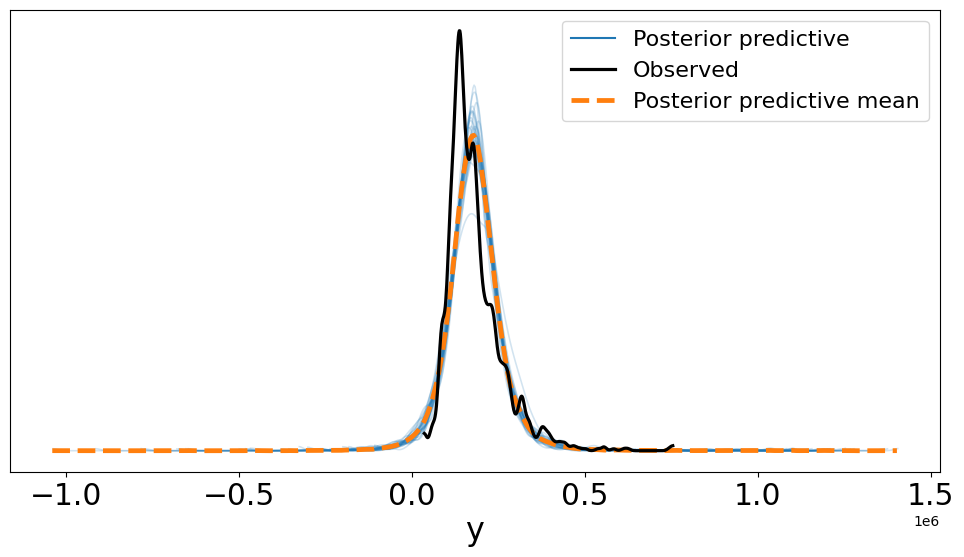

In [108]:
az.plot_ppc(idata, figsize=(12, 6));

По графикам апостериорного распределения параметров видно, что модель также не сходится. Но апостериорное распределение таргета ближе к реальному таргету, чем у предыдущей вероятностной модели с нормальным правдоподобием.

In [109]:
model.predict(idata, kind="response", data=X_test)

In [110]:
idata.posterior_predictive.y

<xarray.DataArray 'y' (chain: 1, draw: 30, __obs__: 1459)> Size: 350kB
array([[[127351.08265134, 281797.58497945, 129204.29782904, ...,
         306087.9720295 , 174264.39064705, 180371.6052742 ],
        [151372.11741877, 201612.42766182,  88970.22239752, ...,
         194970.60671642, 156920.60616395, 198334.02338436],
        [169215.89018776, 269471.20582476, 105905.80207849, ...,
         215712.71428694, 147763.70691071, 204854.18163839],
        ...,
        [159171.73919459, 159120.48817577, 225761.40870309, ...,
         194995.48317041, 243607.36177458, 105764.59191875],
        [113797.59875412, 242772.27401446, 207693.10418901, ...,
         247394.12179297, 334908.88735175, 101562.96877878],
        [137031.61248067, 249739.06994927, 213386.65582702, ...,
         244645.27755479, 151004.73162955, 330445.98654784]]])
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 120B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * __obs__  (__obs__) int32 6kB 0 1 2 3 4 5 6 ... 1453 1454 1455 1456 1457 1458

In [111]:
pred = np.array(idata.posterior_predictive.y.mean(dim=['draw']))[0]

In [112]:
metrics.loc['Bayesian GLM t', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['Bayesian GLM t', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [113]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672
GLM InvGauss,-4.100275,37291.801243
Bayesian LR,-0.318454,18960.470392
Bayesian GLM t,-0.619287,21012.534227


Качество на тестовой выборке также немного лучше.

model = bmb.Model(formula, data, family='wald')
idata = model.fit(draws=30, chains=1, tune=3) # sample

model = bmb.Model(formula, data, family='gamma')
idata = model.fit(draws=30, chains=1, tune=3) # sample

# 2.8 Bayesian LRBayesian GLM tBayesian GLM t 11 num features

Обучим наилучший вариант модели - вероятностную модель с t-распределением - на дополнительных предикторах. Возьмем 11 количественных признаков.

In [114]:
features = ['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces']

In [115]:
columns_alias = {}

for i, col in enumerate(features):
    columns_alias[col] = f'X{i+1}'

In [116]:
data = train_num[features].rename(columns=columns_alias)
data['y'] = train['SalePrice']

In [117]:
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,y
Id,,,,,,,,,,,,
1,8450,2003,2003,196.0,150,856,1710,2,1,8,0,208500
2,9600,1976,1976,0.0,284,1262,1262,2,0,6,1,181500
3,11250,2001,2002,162.0,434,920,1786,2,1,6,1,223500
4,9550,1915,1970,0.0,540,756,1717,1,0,7,1,140000
5,14260,2000,2000,350.0,490,1145,2198,2,1,9,1,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1456,7917,1999,2000,0.0,953,953,1647,2,1,7,1,175000
1457,13175,1978,1988,119.0,589,1542,2073,2,0,7,2,210000
1458,9042,1941,2006,0.0,877,1152,2340,2,0,9,2,266500


In [118]:
formula = 'y ~ ' + ' + '.join(data.drop(columns=['y']).columns.to_list())

In [119]:
formula

'y ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11'

In [128]:
model = bmb.Model(formula, data, family='t')
idata = model.fit(draws=30, chains=1, tune=3) # sample

Only 30 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\Demina.LV\Documents\Scripts\OTUS\.venv\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, nu, Intercept, X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11]


Output()

Sampling 1 chain for 3 tune and 30 draw iterations (3 + 30 draws total) took 1658 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


Sampling: [Intercept, X1, X10, X11, X2, X3, X4, X5, X6, X7, X8, X9, nu, sigma]


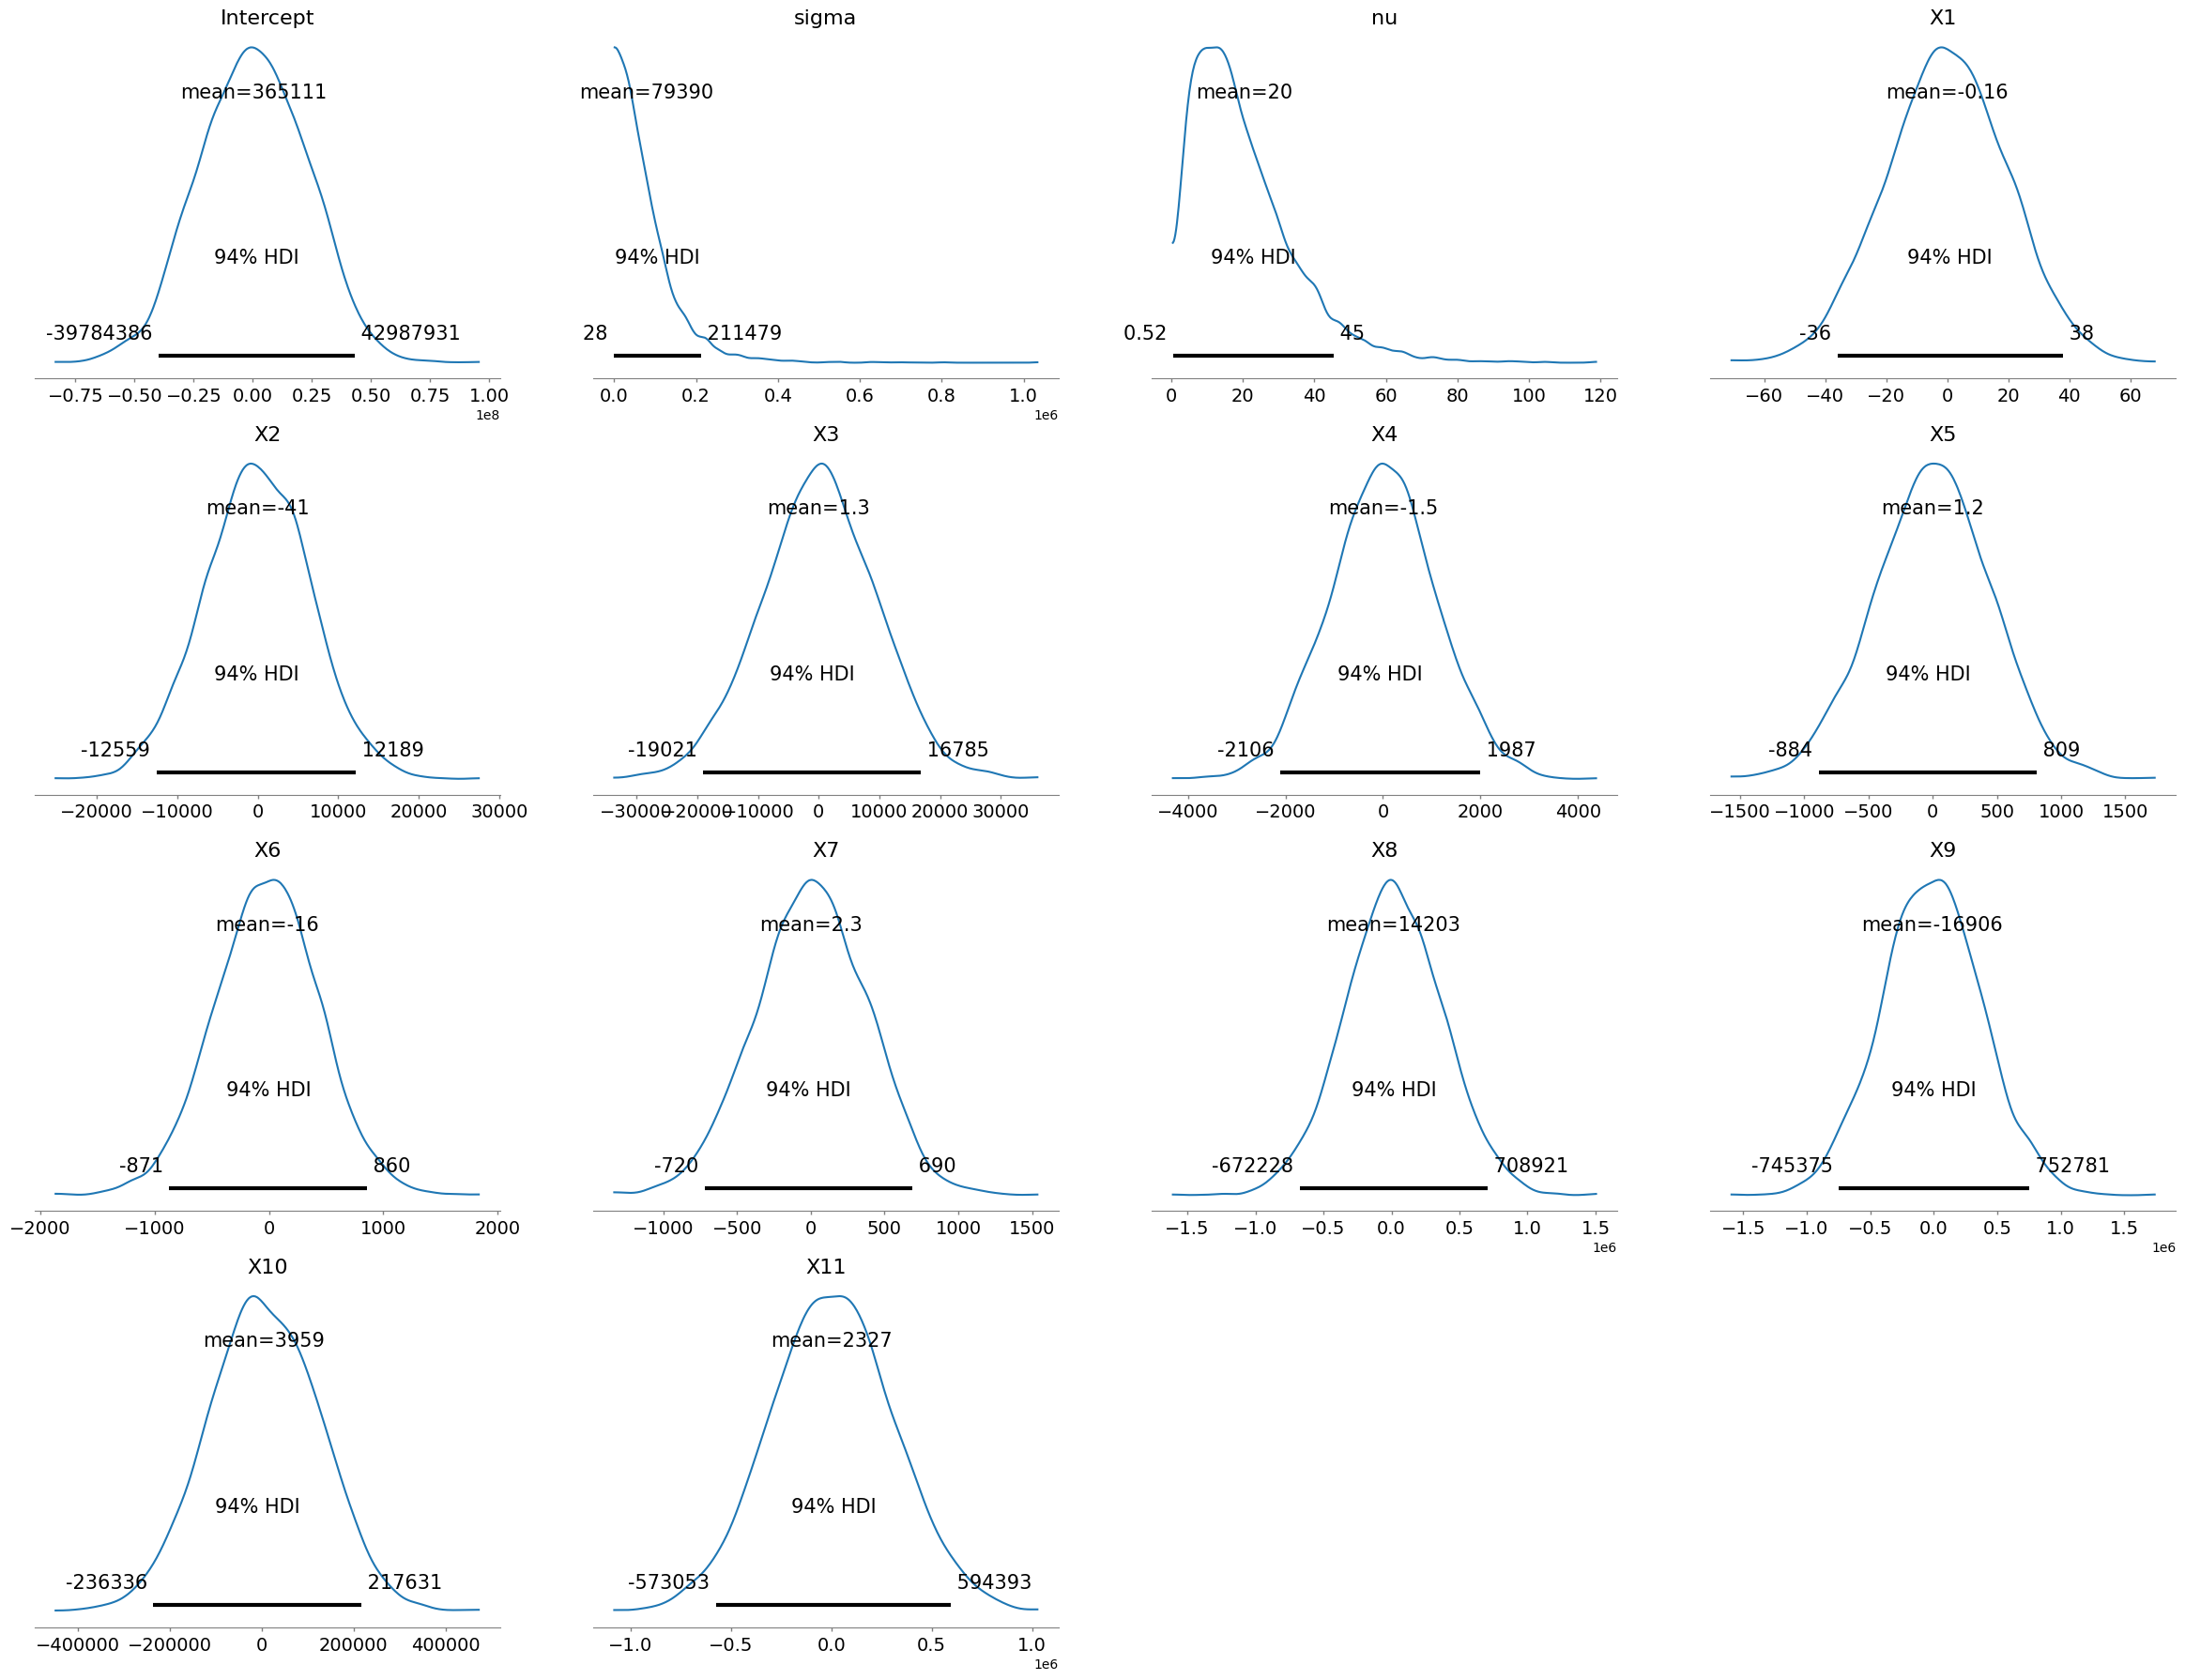

In [129]:
model.plot_priors();

In [130]:
model

       Formula: y ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8 + X9 + X10 + X11
        Family: t
          Link: mu = identity
  Observations: 1460
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 180921.1959, sigma: 23115875.7477)
            X1 ~ Normal(mu: 0.0, sigma: 19.8979)
            X2 ~ Normal(mu: 0.0, sigma: 6575.7338)
            X3 ~ Normal(mu: 0.0, sigma: 9619.8762)
            X4 ~ Normal(mu: 0.0, sigma: 1098.903)
            X5 ~ Normal(mu: 0.0, sigma: 449.4707)
            X6 ~ Normal(mu: 0.0, sigma: 452.7099)
            X7 ~ Normal(mu: 0.0, sigma: 377.9518)
            X8 ~ Normal(mu: 0.0, sigma: 360502.0164)
            X9 ~ Normal(mu: 0.0, sigma: 394933.4474)
            X10 ~ Normal(mu: 0.0, sigma: 122189.6623)
            X11 ~ Normal(mu: 0.0, sigma: 308076.0242)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 79415.2919)
            nu ~ Gamma(alpha: 2.0, beta: 0.1)
------
* To se

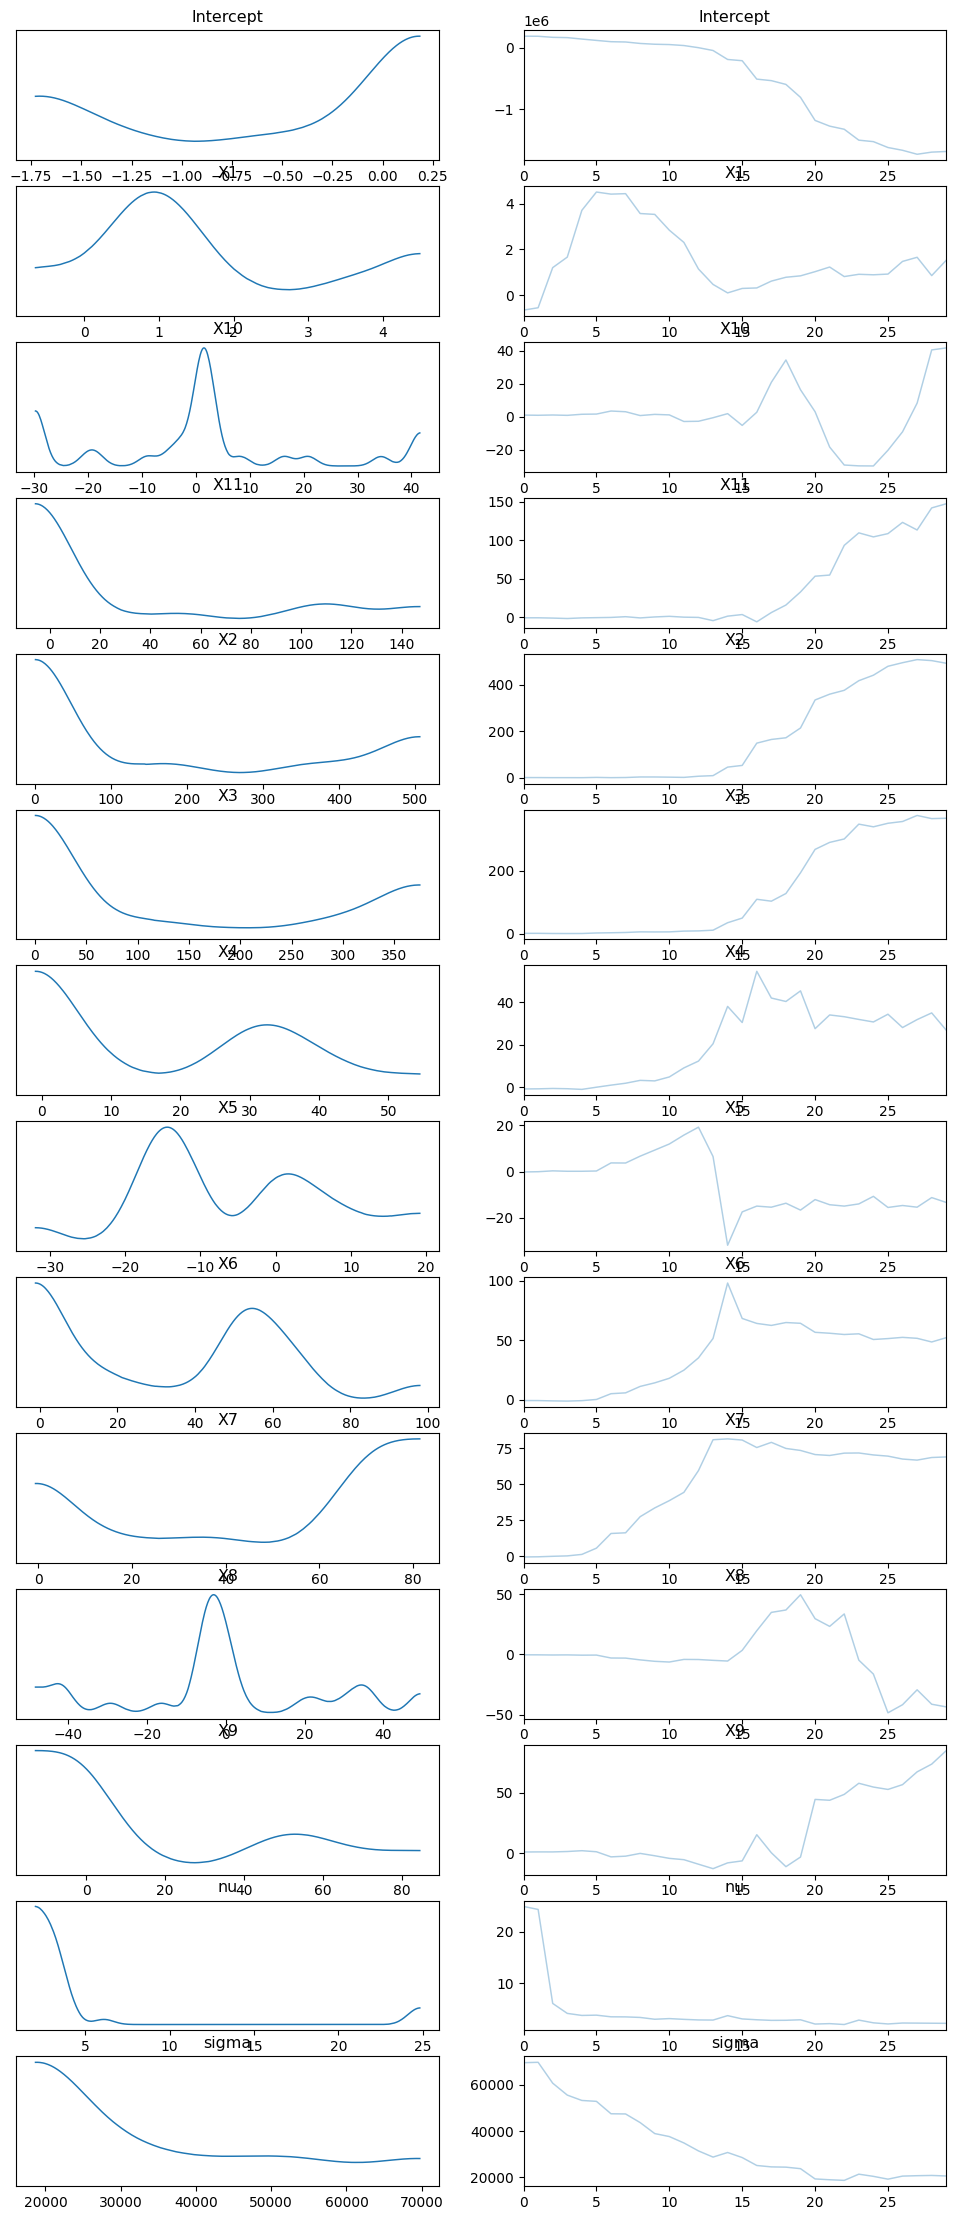

In [131]:
az.plot_trace(idata);

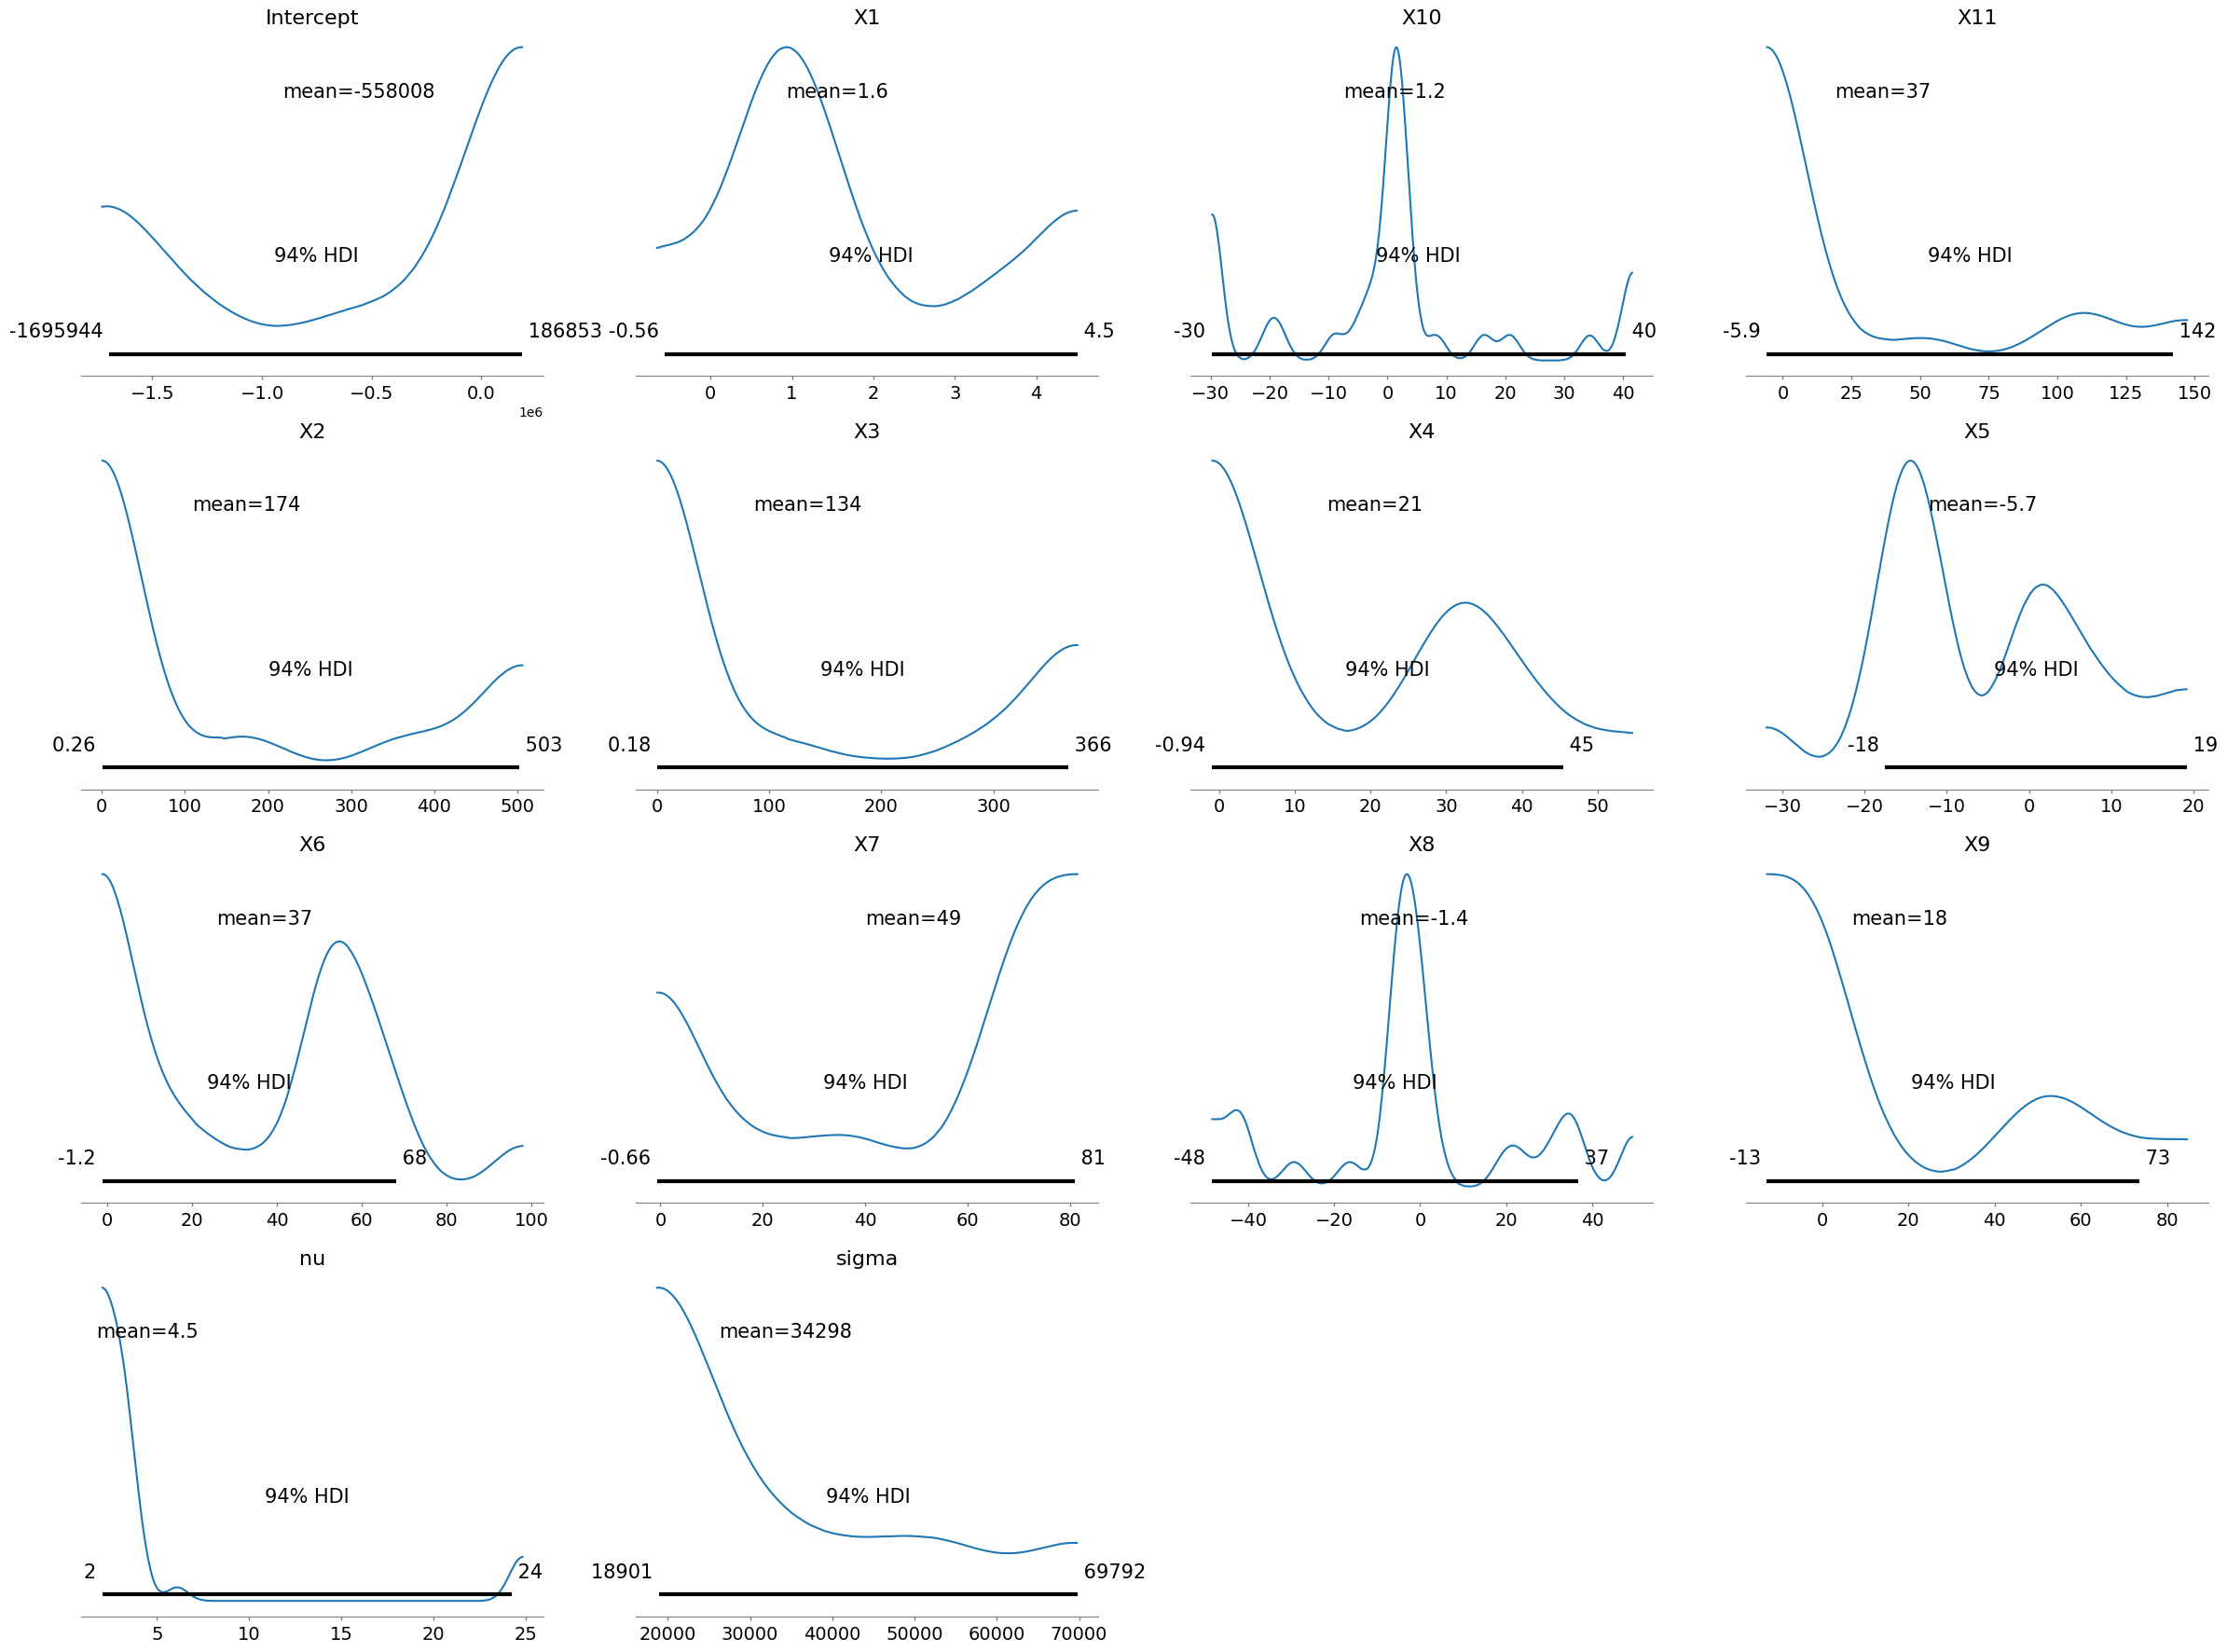

In [132]:
az.plot_posterior(idata);

In [133]:
model.predict(idata, kind='response', inplace=True)

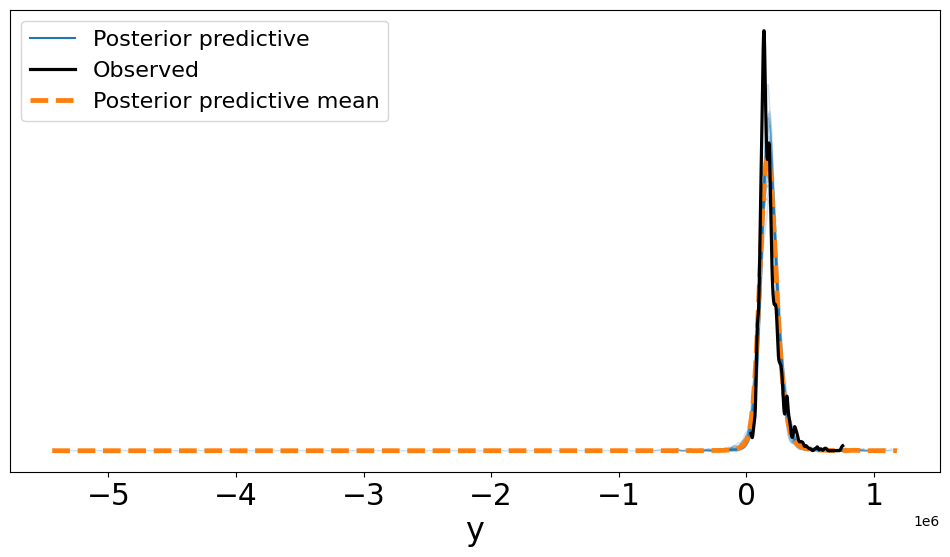

In [134]:
az.plot_ppc(idata, figsize=(12, 6));

In [135]:
X_test = test_num[features].rename(columns=columns_alias)

In [136]:
model.predict(idata, kind="response", data=X_test)

In [137]:
idata.posterior_predictive.y

<xarray.DataArray 'y' (chain: 1, draw: 30, __obs__: 1459)> Size: 350kB
array([[[171680.01856868,  94588.69643462, 322661.34966375, ...,
         118531.83371469, 205379.71720518, 188096.90765081],
        [283663.05923724, 156483.37428329, 270617.76910404, ...,
         188559.79301228, 182534.05775857, 267342.7603417 ],
        [ 84587.04001961, 114652.75739716, 204204.74135494, ...,
         254359.55572197, 223914.57448717, 216870.69627803],
        ...,
        [117535.7250541 , 194282.44156773, 233579.30765726, ...,
         187479.16430509, 149465.53775562, 218764.97302275],
        [137781.52352457, 169626.64703095, 195358.96688136, ...,
         176534.42325843, 222437.35930128, 223346.60077528],
        [ 87511.40002038, 111637.84937771, 158901.03168786, ...,
         195835.9832646 , 165906.43318542, 209754.56698493]]])
Coordinates:
  * chain    (chain) int32 4B 0
  * draw     (draw) int32 120B 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * __obs__  (__obs__) int32 6kB 0 1 2 3 4 5 6 ... 1453 1454 1455 1456 1457 1458

In [138]:
pred = np.array(idata.posterior_predictive.y.mean(dim=['draw']))[0]

In [139]:
metrics.loc['Bayesian GLM t 11 features', 'R2'] = r2_score(sample_sub['SalePrice'], pred)
metrics.loc['Bayesian GLM t 11 features', 'RMSE'] = mean_squared_error(sample_sub['SalePrice'], pred) ** (1/2)

In [140]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672
GLM InvGauss,-4.100275,37291.801243
Bayesian LR,-0.318454,18960.470392
Bayesian GLM t,-0.619287,21012.534227
Bayesian GLM t 11 features,-4.406839,38396.200303


Качество модели с большим числом признаков стало сильно хуже.

# 3 Выводы

В рамках задания нужно было построить интерпретируемую вероятностную модель для задачи регрессии. 

Было рассмотрено несколько моделей GLM с точечной оценкой и вероятностые модели GLM:

1. GLM Gaussian (LinReg)
2. GLM Gaussian на прологарифмированном таргете (LinReg_log)
3. GLM Gamma
4. GLM InverseGaussian
5. Bayesian LR
6. Bayesian GLM с t-распределением

Модели обучались на двух признаках - год постройки и площадь объекта. Затем модель Bayesian GLM с t-распределением была обучена на 11 количественных признаках. Результаты работы на тестовых данных представлены ниже.

In [141]:
metrics

,R2,RMSE
LinReg,-5.920384,43439.180862
LinReg_log,-4.952697,40287.787701
GLM Gamma,-4.214459,37706.931672
GLM InvGauss,-4.100275,37291.801243
Bayesian LR,-0.318454,18960.470392
Bayesian GLM t,-0.619287,21012.534227
Bayesian GLM t 11 features,-4.406839,38396.200303


Наилучшее качество среди моделей с точечной оценкой наблюдается у моделей GLM с распределением InverseGaussian и Gamma, у GLM InverseGaussian метрики немного выше. При этом качество всех моделей достаточно плохое.

Из-за слишком долгой трассировки вероятностных моделей число сэмплов было задано равным 30. По апостериорным распределениям параметров вероятностных моделей видно, что у всех из них плохая сходимость. Качество предсказания на тестовых данных намного выше, чем у моделей с точечной оценкой. При обучении Bayesian GLM с t-распределением на 11 признаках качество на тестовых данных оказалось значительно ниже, чем при ее обучении на 2 признаках.